# Fractional VQE Portfolio Optimization

This notebook implements a **fractional-weight formulation** of the portfolio optimization problem using a **Variational Quantum Eigensolver**.

### Contents

1. **Problem Setup**
   - Expected returns vector $μ$
   - Covariance matrix $Σ$
   - Risk-aversion parameter $λ$

2. **Quantum Ansatz**
   - Hardware-efficient $R_Y$ rotations (one per asset)
   - $⟨Z⟩$ expectation mapped to fractional weights

3. **Cost Function**
   - Mean–variance objective: $−μᵀw + λ wᵀΣw$
   - Soft constraints for $\sum w=1$ and $w ≥ 0$
   - Classical Markowitz enforces hard constraints $w ≥ 0$, $\sum w = 1$.  
   - Fractional VQE relaxes these into **soft penalties**, then normalizes post-optimization.

4. **Optimization**
   - PennyLane `AdamOptimizer` with autograd
   - Track cost convergence across iterations
    
5. **Results & Visualization**
   - Circuit drawing
   - Optimized weights
   - Bar chart and pie chart of allocation
   - Convergence plot

### Notes

- Ansatz is single-layer $R_Y$; extend with entanglers or depth for more expressivity
- Penalty scaling is data-driven
- Use different seeds or $λ$ values to test robustness

#### Normalization

- We map expectations to fractional weights via $w_i = \tfrac{1-⟨Z_i⟩}{2}$ and then **renormalize**: $\tilde w_i = \tfrac{w_i}{\sum_j w_j}$.
- A soft budget penalty enforces $\sum w \approx 1$ during training; post‐normalization guarantees a valid allocation.

#### Penalty design

- Objective used in code:
  $$
  \mathcal{L}(θ) = -μ^\top w(θ) + λ w(θ)^\top Σ w(θ) + β_{\text{sum}} (\sum w(θ) - 1)^2 + β_{\text{neg}} \sum \max (-w(θ),0)
  $$
- $β_{\text{sum}}, β_{\text{neg}}$ are **data‐scaled** from $\|μ\|_1$ and $\operatorname{tr}(Σ)$ so constraint terms are on the same order as the mean–variance terms.

#### λ sweep and efficient frontier

- We re‐optimize for a grid of $λ$ values and plot:
  1) **Allocation sweep** (grouped bars) to show diversification vs $λ$.
  2) **Efficient frontier** using $(σ, R) = (\sqrt{w^\top Σ w}, μ^\top w)$.
- Interpretation: small $λ$ → return‐seeking, concentrated weights; large $λ$ → risk‐averse, diversified weights.

#### Validation and comparability

- Compare $(σ, R)$ points to the **Markowitz** frontier; close alignment indicates the ansatz and penalties are behaving correctly.
- Ensure $Σ$ is positive semidefinite for stability; consider shrinkage if needed.
- Report seed, $λ$, depth, steps, and device settings to make runs reproducible.

#### Reproducibility

- Record random seed, $λ$, penalty coefficients, circuit depth, number of steps, and device backend.  
- Use finite shots for deployment to capture sampling noise.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane import draw_mpl
import os
os.makedirs("images", exist_ok=True)

np.random.seed(0)

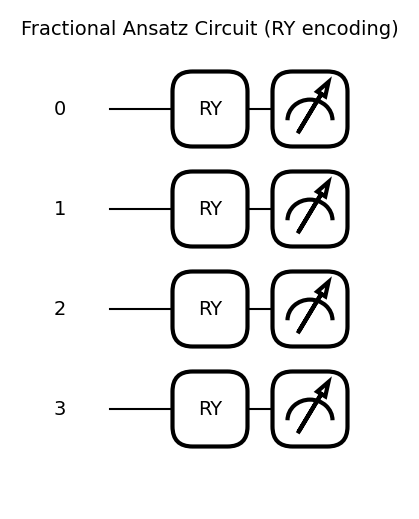

In [2]:
# Problem setup
mu = np.array([0.10, 0.20, 0.15, 0.12], requires_grad=False)  # Expected returns
Sigma = np.array([
    [0.005, -0.010, 0.004, -0.002],
    [-0.010, 0.040, -0.002, 0.004],
    [0.004, -0.002, 0.023, 0.002],
    [-0.002, 0.004, 0.002, 0.018]
], requires_grad=False)

n_assets = len(mu)
lam = 5.0  # Risk aversion parameter

# Quantum device and QNode
dev = qml.device("default.qubit", wires=n_assets, shots=None)

@qml.qnode(dev, interface="autograd")
def qnode(thetas):
    # Hardware-efficient R_Y layer
    for i in range(n_assets):
        qml.RY(thetas[i], wires=i)

    # Return ⟨Z⟩ for each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_assets)]

def angles_to_weights(thetas):
    # From ⟨Z⟩ to probability of |1⟩
    z = qml.math.stack(qnode(thetas))
    w = (1.0 - z) * 0.5  # In [0,1]

    # Soft simplex projection via normalization
    s = qml.math.sum(w)
    return w / (s + 1e-12), z

def scaled_penalty(mu, Sigma):
    # Scale penalties to objective magnitude
    ret_scale = float(np.sum(np.abs(mu)))
    risk_scale = float(np.trace(Sigma))
    base = max(ret_scale, risk_scale, 1e-3)
    return 50.0 * base, 10.0 * base

def objective(thetas):
    w, _ = angles_to_weights(thetas)
    expected_return = qml.math.dot(mu, w)
    risk = qml.math.dot(w, qml.math.dot(Sigma, w))

    # Soft constraints
    p_sum, p_neg = scaled_penalty(mu, Sigma)
    c_sum = p_sum * (qml.math.sum(w) - 1.0) ** 2
    c_neg = p_neg * qml.math.sum(qml.math.maximum(-w, 0.0))  # Barrier if any w<0 (rare but safe)
    return -(expected_return) + lam * risk + c_sum + c_neg

# Draw the circuit
sample_thetas = np.linspace(0, np.pi, n_assets)
fig, ax = draw_mpl(qnode)(sample_thetas)
fig.suptitle("Fractional Ansatz Circuit (RY encoding)", fontsize=14)
plt.savefig("images/Fractional_VQE_Circuit.png", dpi=300, bbox_inches="tight")
plt.show()

In [3]:
# Optimize
thetas = np.array(np.random.uniform(0, np.pi, n_assets), requires_grad=True)
opt = qml.AdamOptimizer(stepsize=0.3)
steps = 75
history = []

for t in range(steps):
    thetas, cost = opt.step_and_cost(objective, thetas)
    if (t+1) % 5 == 0:
        w, z = angles_to_weights(thetas)
        history.append(float(cost))
        print(f"step {t+1:03d}  cost={float(cost):.6f}  sum(w)={float(np.sum(w)):.4f}")

step 005  cost=-0.122992  sum(w)=1.0000
step 010  cost=-0.124693  sum(w)=1.0000
step 015  cost=-0.124709  sum(w)=1.0000
step 020  cost=-0.124698  sum(w)=1.0000
step 025  cost=-0.124784  sum(w)=1.0000
step 030  cost=-0.124766  sum(w)=1.0000
step 035  cost=-0.124786  sum(w)=1.0000
step 040  cost=-0.124824  sum(w)=1.0000
step 045  cost=-0.124890  sum(w)=1.0000
step 050  cost=-0.124871  sum(w)=1.0000
step 055  cost=-0.124897  sum(w)=1.0000
step 060  cost=-0.124888  sum(w)=1.0000
step 065  cost=-0.124896  sum(w)=1.0000
step 070  cost=-0.124894  sum(w)=1.0000
step 075  cost=-0.124897  sum(w)=1.0000


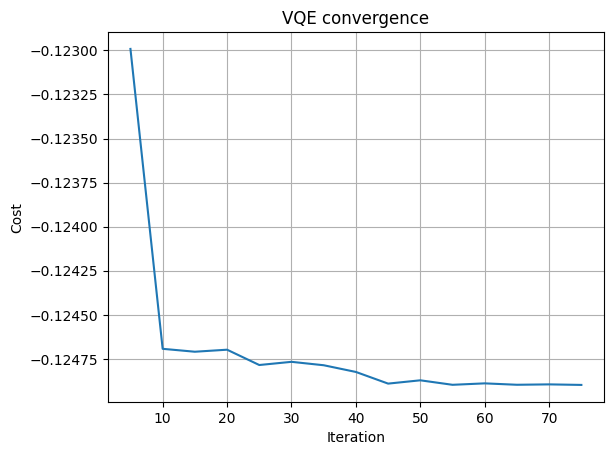

In [4]:
# Convergence plot
plt.figure()
plt.plot(range(5, steps+1, 5), history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("VQE convergence")
plt.grid(True)
plt.savefig("images/Fractional_VQE_Convergence.png", dpi=300, bbox_inches="tight")
plt.show()

In [5]:
# Results
w_opt, _ = angles_to_weights(thetas)
w_opt = w_opt / (np.sum(w_opt) + 1e-12)

print("\nOptimized allocation")
for i, w in enumerate(w_opt):
    print(f"Asset {i+1}: {float(w)*100:.2f}%")


Optimized allocation
Asset 1: 48.19%
Asset 2: 35.64%
Asset 3: 13.06%
Asset 4: 3.11%


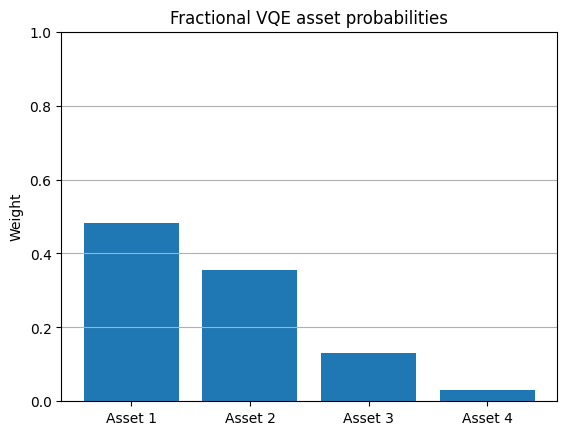

In [6]:
# Bar chart
plt.figure()
plt.bar([f"Asset {i+1}" for i in range(n_assets)], w_opt)
plt.ylabel("Weight")
plt.ylim(0, 1)
plt.title("Fractional VQE asset probabilities")
plt.grid(axis="y")
plt.savefig("images/Fractional_VQE_Probabilities.png", dpi=300, bbox_inches="tight")
plt.show()

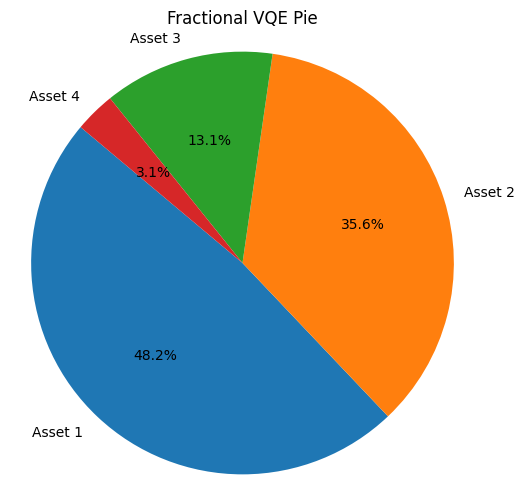

In [7]:
# Pie chart
plt.figure(figsize=(6,6))
plt.pie(w_opt, labels=[f"Asset {i+1}" for i in range(n_assets)], autopct="%1.1f%%", startangle=140)
plt.title("Fractional VQE Pie")
plt.axis("equal")
plt.savefig("images/Fractional_VQE_Pie.png", dpi=300, bbox_inches="tight")
plt.show()

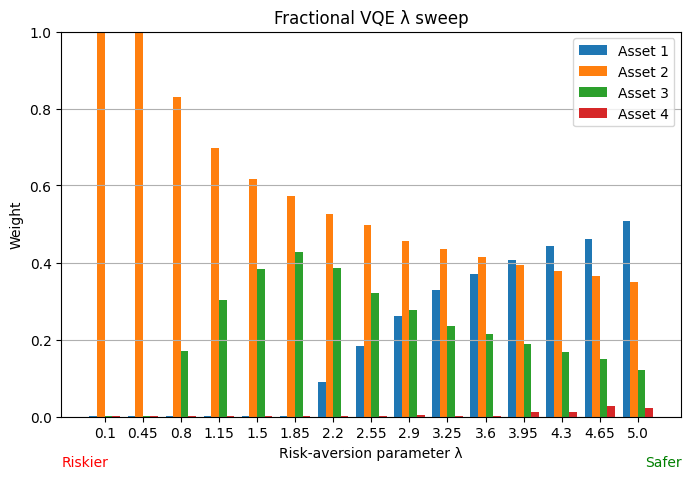

In [11]:
# λ sweep
# Vary risk aversion λ, re-optimize briefly, and plot marginal inclusion probabilities.
lambdas = np.round(np.linspace(0.1, 5.0, 15, dtype=float), 2)
allocs = []
for lam in lambdas:
    def obj_lam(th):  # wrap with new λ
        w, _ = angles_to_weights(th)
        ret = qml.math.dot(mu, w)
        risk = qml.math.dot(w, qml.math.dot(Sigma, w))
        p_sum, p_neg = scaled_penalty(mu, Sigma)
        return -(ret) + lam * risk + p_sum * (qml.math.sum(w)-1)**2 + p_neg * qml.math.sum(qml.math.maximum(-w, 0.0))
    th = np.array(np.random.uniform(0, np.pi, n_assets), requires_grad=True)
    opt = qml.AdamOptimizer(0.2)
    for _ in range(60): th, _ = opt.step_and_cost(obj_lam, th)
    w, _ = angles_to_weights(th)
    w = w/(np.sum(w)+1e-12)
    allocs.append(qml.numpy.array(w))
allocs = np.vstack(allocs)

# Plot grouped bar chart
x = np.arange(len(lambdas))
bw = 0.2
plt.figure(figsize=(8,5))
for i in range(n_assets): plt.bar(x+i*bw, allocs[:, i], bw, label=f"Asset {i+1}")
plt.xticks(x + bw*(n_assets-1)/2, [f"{l}" for l in lambdas])
plt.ylim(0,1)
plt.xlabel("Risk-aversion parameter λ")
plt.ylabel("Weight")
plt.title("Fractional VQE λ sweep")
plt.legend()
plt.grid(axis="y")
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.text(xmin, ymin - 0.1, "Riskier", ha="left", va="top", fontsize=10, color="red")
plt.text(xmax, ymin - 0.1, "Safer", ha="right", va="top", fontsize=10, color="green")
plt.savefig("images/Fractional_VQE_Lambda_Sweep.png", dpi=200, bbox_inches="tight")
plt.show()

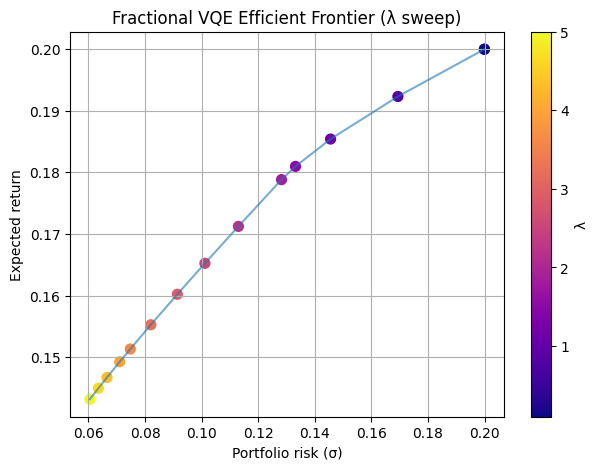

In [9]:
# Efficient frontier for Fractional VQE
returns_vqe = []
risks_vqe = []

for w in allocs:
    R = float(mu @ w)
    sigma2 = float(w.T @ Sigma @ w)
    returns_vqe.append(R)
    risks_vqe.append(np.sqrt(sigma2))

returns_vqe = np.array(returns_vqe)
risks_vqe = np.array(risks_vqe)

# Sort by risk for smooth curve
order = np.argsort(risks_vqe)
risks_vqe = risks_vqe[order]
returns_vqe = returns_vqe[order]
lambdas_sorted = lambdas[order]

plt.figure(figsize=(7,5))
sc = plt.scatter(risks_vqe, returns_vqe, c=lambdas_sorted, cmap="plasma", s=50)
plt.plot(risks_vqe, returns_vqe, alpha=0.6)
cbar = plt.colorbar(sc)
cbar.set_label("λ")
plt.xlabel("Portfolio risk (σ)")
plt.ylabel("Expected return")
plt.title("Fractional VQE Efficient Frontier (λ sweep)")
plt.grid(True)
plt.savefig("images/Fractional_VQE_Efficient_Frontier.png", dpi=200, bbox_inches="tight")
plt.show()